In [36]:
import pandas as pd
from pathlib import Path
import sys
import os
import numpy as np
import re


sys.path.append(os.path.abspath('../src'))
project_dir = project_dir = Path.cwd().parent

In [37]:
# Combine all excel files into one df

def agg_sero(label):
    return label[1:] if label.startswith('h') else label

base_folder_path = project_dir / "data" / "raw" / "DENV"
files = [f for f in os.listdir(base_folder_path) if f.endswith('.xlsx')]
dfs = []


for file in files:

    file_path = os.path.join(base_folder_path, file)
    all_sheets = pd.read_excel(file_path, sheet_name=None)
    for sheet_name, df_folder in all_sheets.items():
        df_folder = df_folder.assign(source_file=file, sheet_name=sheet_name)

        # Create EPI index
        EPI = df_folder['seqName'].str.split('|', expand=True) [1]
        df_folder['EPI'] = EPI
        # Create Serotype col
        sero = df_folder['seqName'].str.split('|', expand=True)[0].str.split('/', expand=True)[0]
        df_folder['Sero'] = [agg_sero(s) for s in sero]

        # Create Genotype col (only looking a major lineages)
        try:
            geno = df_folder['clade'].str.split('_', expand=True)[0]
        except:
            geno = 'unassigned'
        df_folder['Geno'] = geno

        dfs.append(df_folder)

denv_df = pd.concat(dfs)

In [38]:
print(denv_df['Sero'].unique())
print(denv_df['Geno'].unique())

['DenV1' 'DenV3' 'DenV2' 'DenV4']
['1V' '1IV' 'unassigned' '2III' '2I' '2V' '3V' '3I' '3III' '4II' '4I'
 '2II' '1III']


In [39]:
# Merge in Dates of collectiona and submission
denv_dates = pd.read_csv(os.path.join(base_folder_path, "DENV dates.tsv"), sep='\t')
denv_df = denv_df.merge(denv_dates, left_on='EPI', right_on='Accession ID', how='left')

denv_df = denv_df[["EPI", "Sero", "Geno", "Collection date", "Submission date"]]

In [40]:
# Format dates to Year-Month, with only year readings assumed to be Jan
def fix_date(val):
    if isinstance(val, str):
        val = val.strip()

        # Year only: "2018"
        if re.fullmatch(r"\d{4}", val):
            return f"{val}-01-01"
        
        # Year-Month: "2018-07" or "2018/07"
        if re.fullmatch(r"\d{4}[-/]\d{1,2}", val):
            parts = re.split("[-/]", val)
            year, month = parts
            return f"{year}-{int(month):02d}-01"
        
        # Month-Year: "07/2018" or "07-2018"
        if re.fullmatch(r"\d{1,2}[-/]\d{4}", val):
            parts = re.split("[-/]", val)
            month, year = parts
            return f"{year}-{int(month):02d}-01"
        
    return val  # Leave as-is if not matched

# Clean up dates on monthly scale
denv_df['Collection date'] = denv_df['Collection date'].apply(fix_date)
denv_df['Submission date'] = denv_df['Submission date'].apply(fix_date)

denv_df['Collection date'] = pd.to_datetime(denv_df['Collection date']).dt.to_period('M')
denv_df['Submission date'] = pd.to_datetime(denv_df['Submission date']).dt.to_period('M')


denv_df['Delay'] = np.array((denv_df['Submission date'] - denv_df['Collection date']).apply(lambda x: x.n))
denv_df = denv_df.sort_values("Collection date")
denv_df


,EPI,Sero,Geno,Collection date,Submission date,Delay
6539,EPI_ISL_17568967,DenV1,unassigned,2000-01,2007-11,94
5515,EPI_ISL_17568508,DenV1,1V,2000-01,2010-06,125
5655,EPI_ISL_17568898,DenV2,2III,2000-01,2012-09,152
5523,EPI_ISL_17568518,DenV1,1V,2000-01,2010-06,125
5524,EPI_ISL_17568520,DenV1,1V,2000-01,2010-06,125
...,...,...,...,...,...,...
3669,EPI_ISL_19076603,DenV1,1V,2023-12,2024-04,4
3668,EPI_ISL_19076602,DenV1,1V,2023-12,2024-04,4
3667,EPI_ISL_19076601,DenV1,1V,2023-12,2024-04,4
3674,EPI_ISL_19076608,DenV1,1V,2023-12,2024-04,4


In [49]:
denv_df.to_csv(project_dir / "data" / "transformed" / 'denv_df.csv', index=False)

Create Proportions

In [42]:
# Create full grid of Month × Sero combinations
start_month = denv_df['Collection date'].min()
end_month = denv_df['Collection date'].max()
months_all = pd.period_range(start=start_month, end=end_month, freq='M')
sero_all = denv_df['Sero'].unique()



sero_date_combos = pd.MultiIndex.from_product(
    [months_all, sero_all], names=['Collection date', 'Sero']
).to_frame(index=False)

sero_counts = denv_df.groupby(['Collection date', 'Sero']).size().reset_index(name='Count')
sero_full_counts = pd.merge(sero_date_combos, sero_counts, on=['Collection date', 'Sero'], how='left')
sero_full_counts['Count'] = sero_full_counts['Count'].fillna(0).astype(int)
sero_full_counts['Proportion'] = sero_full_counts['Count'] / sero_full_counts.groupby('Collection date')['Count'].transform('sum')
sero_full_counts = sero_full_counts.sort_values(['Sero', 'Collection date']).reset_index(drop=True)
sero_full_counts

# will contain NaN for months that had no obs
unobserved_months = sero_full_counts[sero_full_counts['Proportion'].isna()]['Collection date'].unique()
print(unobserved_months)

# Need to backfill with a previous months prop
for month in unobserved_months:
    filled = False
    for lag in range(1, 12):
        prev_month = month - lag
        prev_vals = sero_full_counts.loc[
            sero_full_counts['Collection date'] == prev_month, 'Proportion'
        ]

        if not prev_vals.empty and not prev_vals.isna().any():
            sero_full_counts.loc[
                sero_full_counts['Collection date'] == month, 'Proportion'
            ] = prev_vals.values
            filled = True
            break  # Exit the lag loop

    if not filled:
        print(f"[Warning] Not enough data to backfill for month {month}. Collect more data!")


sero_full_counts



<PeriodArray>
['2000-02', '2000-03', '2000-04', '2000-06', '2000-07', '2000-08', '2000-09',
 '2000-10', '2000-11', '2000-12',
 ...
 '2016-11', '2016-12', '2017-08', '2017-09', '2017-11', '2017-12', '2019-10',
 '2020-08', '2020-09', '2020-10']
Length: 107, dtype: period[M]


,Collection date,Sero,Count,Proportion
0,2000-01,DenV1,23,0.676471
1,2000-02,DenV1,0,0.676471
2,2000-03,DenV1,0,0.676471
3,2000-04,DenV1,0,0.676471
4,2000-05,DenV1,0,0.000000
...,...,...,...,...
1147,2023-08,DenV4,0,0.000000
1148,2023-09,DenV4,0,0.000000
1149,2023-10,DenV4,0,0.000000
1150,2023-11,DenV4,1,0.015873


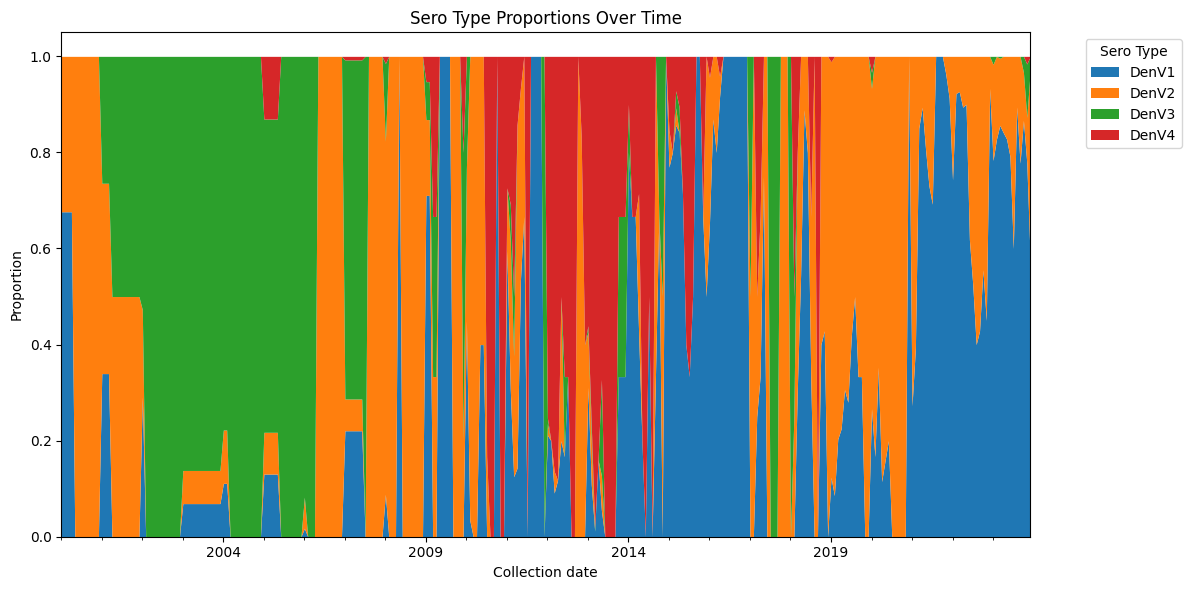

In [43]:
import pandas as pd
import matplotlib.pyplot as plt


sero_full_counts = sero_full_counts.sort_values('Collection date')

# Pivot to wide format: rows = dates, columns = Sero, values = Proportion
pivot_df = sero_full_counts.pivot(index='Collection date', columns='Sero', values='Proportion')
pivot_df = pivot_df.fillna(0)  # Fill missing with 0

# Plot stacked area chart
pivot_df.plot.area(figsize=(12, 6), linewidth=0)
plt.ylabel("Proportion")
plt.title("Sero Type Proportions Over Time")
plt.legend(title="Sero Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [44]:
sero_pivot = sero_full_counts.pivot(index='Collection date', columns='Sero', values='Proportion')
sero_pivot.to_csv(project_dir / "data" / "transformed" / 'sero_props.csv', index=True)
sero_pivot

Sero,DenV1,DenV2,DenV3,DenV4
Collection date,,,,
2000-01,0.676471,0.323529,0.000000,0.000000
2000-02,0.676471,0.323529,0.000000,0.000000
2000-03,0.676471,0.323529,0.000000,0.000000
2000-04,0.676471,0.323529,0.000000,0.000000
2000-05,0.000000,1.000000,0.000000,0.000000
...,...,...,...,...
2023-08,0.894737,0.105263,0.000000,0.000000
2023-09,0.777778,0.222222,0.000000,0.000000
2023-10,0.866667,0.100000,0.033333,0.000000


In [48]:
date = pd.to_datetime("2024-01").to_period('M')
obs = denv_df.loc[denv_df['Submission date'] < date].copy()

obs['Date diff'] = (obs['Collection date'] - date).apply(lambda x: x.n)
obs

,EPI,Sero,Geno,Collection date,Submission date,Delay,Date diff
6539,EPI_ISL_17568967,DenV1,unassigned,2000-01,2007-11,94,-288
5515,EPI_ISL_17568508,DenV1,1V,2000-01,2010-06,125,-288
5655,EPI_ISL_17568898,DenV2,2III,2000-01,2012-09,152,-288
5523,EPI_ISL_17568518,DenV1,1V,2000-01,2010-06,125,-288
5524,EPI_ISL_17568520,DenV1,1V,2000-01,2010-06,125,-288
...,...,...,...,...,...,...,...
4045,EPI_ISL_18669029,DenV4,4II,2023-11,2023-12,1,-2
4039,EPI_ISL_18602073,DenV3,3III,2023-11,2023-12,1,-2
4001,EPI_ISL_18679935,DenV2,2II,2023-11,2023-12,1,-2
4002,EPI_ISL_18679936,DenV2,2II,2023-11,2023-12,1,-2
